# TP1 Simulación

## Ejercicio 1


En esta primera sección se implementa el generador lineal congruencial de números pseudo-aleatorios. Para esto se implementa una función (`own_rand`) con una variable persistente (`own_rand.x_n`), la cual es reemplazada por su sucesor luego de cada llamada.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from statistics import mean, variance

def own_rand():
    own_rand.x_n = (own_rand.x_n * 1013904223 + 1664525) % (2 ** 32)
    return own_rand.x_n

own_rand.x_n = (97925 + 94038 + 97811)/3

In [2]:
import matplotlib
print matplotlib.__version__

2.2.3


In [15]:
result_1a = [own_rand() for i in range(6)]
result_1a

[180184926, 937753583, 1575534782, 571557519, 3756937758, 2724223279]

Luego, para que generar un número pseudo-aleatorio entre 0 y 1, se utiliza la función antes desarrollada y simplemente se la escala diviendo su resultado por el valor máximo de la función utilizada mas uno. Esto hace que el intervalo de números generados sea abierto en su extremo derecho. Aunque esto no es muy relevante ya que la posibilidad de generar exactamente un 1, si el intervalo fuera cerrado, es de 1 en 4 millones aproximadamente.

Tambien se provee una función para generar un vector de estos numeros aleatorios (`rand_u_vector(n)`).

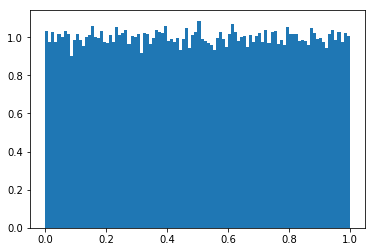

In [18]:
def own_rand_u():
    return float(own_rand())/(2**32)

def rand_u_vector(n):
    return [own_rand_u() for i in range(n)]

result_1b = rand_u_vector(10**5)
plt.hist(result_1b, bins=100, density=True)
plt.show()

## Ejercicio 2


En este ejercicio se genera una muestra de una población de variables aleatorias con distribución exponencial de media $15$, o lo que es equilavente, con un párametro lambda de $1/15$ a través del método de la distribución inversa. 

Para esto se generó una función (`make_exponential_dist_inverse`) que dado el parámetro lambda devuelva la función inversa de la distribución exponencial de ese parámetro (`inverse_dist`). Luego, se generó un vector de números aleatorios de distribución $U(0,1)$, a través de lo desarrollado en el ejercicio anterior, y se aplicó la función antes mencionada a cada elemento del vector. Finalmente, se imprimió un histograma. 

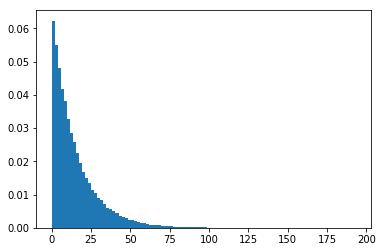

In [17]:
def make_exponential_dist_inverse(lamda):
    inverse_dist = lambda u : -math.log(u)/lamda
    return inverse_dist

inverse_dist = make_exponential_dist_inverse(1.0/15)
inverse_dist = np.vectorize(inverse_dist)

exponential_sample = inverse_dist(rand_u_vector(10**5))

bins_values, bins_edges, _ = plt.hist(exponential_sample,bins=100, density=True)
bins_exp = zip(bins_values, bins_edges[:-1])
plt.show()

Luego, para calcular la media asi como la varianza se utilizan las funciones provistas por el módulo `statistics` las cuales usan el estimador correspondiente no sesgado.

Para el caso de la moda, no se pudo utilizar este módulo ya que la muestra contiene, casi seguramente, todos números distintos por el tamaño del universo de números posibles a genear, el cual es extremadamente grande comparado con el tamaño de la muestra generada. Por ello se utilizó las agrupaciones que hizo el histograma antes mostrado y se mostro el borde izquierdo del bin que contuviera mas muestras. 

In [6]:
mean_exp = mean(exponential_sample)
mode_exp = max(bins_exp, key=(lambda x: x[0]))[1] # Use the first argument as the key to be maxed but return the left edge of the bin which it belongs to
variance_exp = variance(exponential_sample, mean_exp)
mean_exp, mode_exp, variance_exp

(15.07706133918617, 0.00014216473640023047, 227.78817359807297)

Como se puede ver, los valores obtenidos son valores bastante parecidos a los teoricos, los cuales son $15$, $0$ y $15^2$ $(225)$ para la media, la moda y la varianza respectivamente.

## Ejercicio 3

En este ejercicio se generó una muestra aleatoria de una $N(0,1)$, se utilizó una técnica muy similar a la anterior. Lo único destacable es la utilización de la función de distribución inversa ya provista por python (`norm.ppf`) ya que esta función no es alcanzable como combinación de funciones comunes.

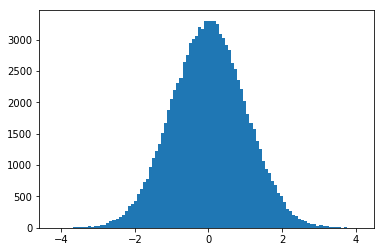

In [19]:
def make_normal_dist_inverse(mu, sigma):
    inverse_dist = lambda u : norm.ppf(u) * sigma + mu
    return inverse_dist

normal_inverse_dist = make_normal_dist_inverse(0, 1)
normal_inverse_dist = np.vectorize(normal_inverse_dist)
normal_sample = normal_inverse_dist(rand_u_vector(10**5))
bins_values, bins_edges, _ = plt.hist(normal_sample, bins=100)
bins_normal = zip(bins_values, bins_edges[:-1])
plt.show()

In [20]:
mean_normal = mean(normal_sample)
mode_normal = max(bins_normal, key=(lambda x: x[0]))[1] # Use the first argument as the key to be maxed but return the left edge of the bin which it belongs to
variance_modal = variance(normal_sample, mean_normal)
mean_normal, mode_normal, variance_modal

(0.004380090973300718, -0.043977305852406445, 0.9985021006110877)

***Nota: Comparada con los valores esperados (0, 0 y 1), los valores generados son bastantes cercanos.***

## Ejercicio 4

  En este ejercicio debemos simular una variable aleatoria, X, con distribución $N(\mu=35,\sigma=5)$ a través del metodo de acepto-rechazo.

  Para hacer esto primero simularemos $|Z|$ donde $Z$ es una variable aleatoria de distribución $N(0,1)$. Luego, multiplicaremos con probabilidad igual a $1/2$ a $|Z|$ por $-1$, con esto logramos obtener otra variable aleatoria con una distribución igual a la de $Z$. Finalmente, multiplicaremos esta ultima variable aleatoria por $5$ y luego le sumaremos $35$ para obtener la variable finalmente deseada, $X$.
  
  Para obtener $|Z|$ es donde se utilizara el metodo acepto-rechazo. Para ello utilizaremos una variable aleatoria exponencial. Por lo tanto, primeramente debemos calcular:

$$c \;\; \mid \;\; pdf_{|Z|} (x) \leq c \cdot pdf_{E}(x) \quad \forall \; x $$

Con unas pocas cuentas se obtiene que la $c$ minima que cumple esto es $1.32$ aprox.  
 
  Luego, se imprime un histograma de una muestra generada mediante el metodo antes mencionada y un histograma de una muestra generada por una función provista por python de manera superpuesta.

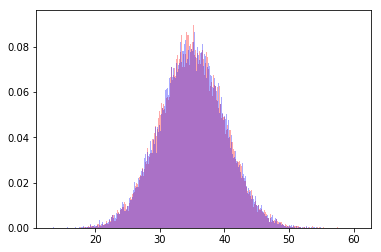

In [24]:
lamda = 1
c = 1.32

def norm_pdf(x, loc, scale):
    return norm.pdf(x, loc=loc, scale=scale)

def random_exp(lamda):
    exponential_dist_inverse = make_exponential_dist_inverse(lamda)
    return exponential_dist_inverse(own_rand_u())

def make_exp_pdf(lamda):
    exp_pdf = lambda x : lamda * math.exp(-lamda * x)
    return exp_pdf

own_exp_pdf = make_exp_pdf(lamda)

def make_norm_acc_rej(loc=0, scale=1):
    def norm_acc_rej():
        start = True
        while start or y > norm_pdf(x, 0, 1):
            start = False
            x = random_exp(lamda)
            y = own_rand_u() * c * own_exp_pdf(x)
            sign = 1 if own_rand_u() < 0.5 else -1
        return x * scale * sign + loc
    return norm_acc_rej

def norm_acc_rej_vector(qty, loc=0, scale=1):
    own_acc_rej = make_norm_acc_rej(loc, scale)
    return [own_acc_rej() for i in range(qty)]

normal_sample2 = norm_acc_rej_vector(10**5, 35, 5)

bins_values, bins_edges, _ = plt.hist(normal_sample2, bins=1000, color='#ff000055', density=True)
bins_normal = zip(bins_values, bins_edges[:-1])

normal_control_group = [np.random.normal() * 5 + 35 for i in range(10**5)]
plt.hist(normal_control_group, bins=1000, color='#0000ff55', density=True)
                                    
plt.show()


Como se puede ver, los gráficos generados son bastante parecidos.

In [23]:
mean_normal2 = mean(normal_sample2)
mode_normal2 = max(bins_exp, key=(lambda x: x[0]))[1] # Use the first argument as the key to be maxed but return the left edge of the bin which it belongs to
variance_normal2 = variance(normal_sample2, mean_normal2)
mean_normal2, mode_normal2, variance_normal2

(34.976932252361586, 0.00014216473640023047, 25.099384668659454)

Los valores dados coinciden con los esperados (35, 0, 25)

# Ejercicio 5

Para este ejercicio, se genero una muestra de una variable aleatoria discreta con una distribución arbitraria. Para esto se programó la función de distribución inversa y se utilizo esta función sobre una muestra de variables aleatorias uniforme como la de ejercicios anteriores.


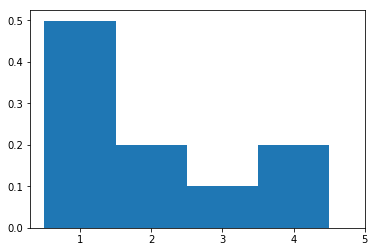

In [10]:
def empiric_inv_distribution(u):
    if u <= 0.5:
        return 1
    elif u <= 0.7:
        return 2
    elif u <= 0.8:
        return 3
    else:
        return 4
    
def gen_empiric():
    return empiric_inv_distribution(own_rand_u())

empiric_sample = [gen_empiric() for i in range(10**5)]


bins_empiric = np.arange(0.5, 5.5, 1)

plt.hist(empiric_sample, bins=bins_empiric, density=True)
plt.xticks(np.arange(1,6,1))
plt.show()

El gráfico se obtuvo a partir de realizar un histograma sobre los valores que puede retornar la variable.

## Ejercicio 6

De una manera similar a la del ejercicio anterior se genero una muestra de una variable aleatoria con distribución Bernoulli de párametro 0.5, ya que cada lanzamiento de la moneda se puede modelar con una variable aleatoria de distribución Bernoulli. 

  Luego, se simuló a partir de la simulación mencionada en el párrafo anterior el experimento de "tirar una moneda hasta encontrar una cara", y se muestra empiricamente como los resultados de este experimento sigue una distribución Geometrica de media 0.5.

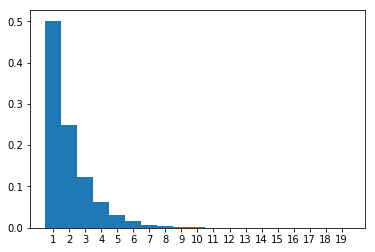

In [25]:
def bernoulli_random():
    return 1 if own_rand_u() < 0.5 else 0

def geometric_random():
    qty = 1
    while bernoulli_random() != 1:
        qty += 1
    return qty

geometric_sample = [geometric_random() for i in range(10**5)]

bins_geometric = np.arange(0.5, 20, 1)

plt.hist(geometric_sample, bins=bins_geometric, density=True)
plt.xticks(np.arange(1,20,1))
plt.show()

## Ejercio 7


Para realizar un test espectral sobre nuestro generador, primero generamos una muestra.

Luego agrupamos los elementos de a pares o de a ternas (según corresponda) consecutivas y no superpuestas. 

Para agruparlos de esta manera en duplas, se recorta la lista en el máximo tamaño posible multiplo de 2, se toman los elementos con indice par por un lado y por otro solo los de indice impar, preservando el orden, y finalmente se pasa a la función graficadora la primera y la segunda lista, las cuales serán utilizadas como valores x e y de los puntos, respectivamente.

Para las ternas el procedimiento es análogo.

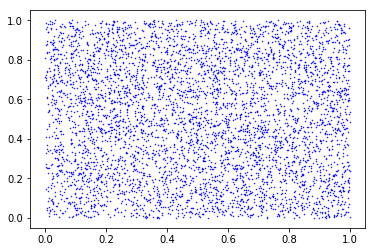

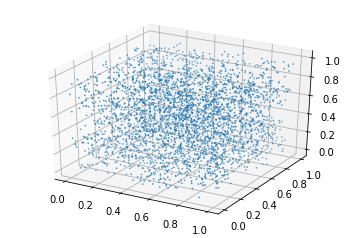

In [26]:
from mpl_toolkits.mplot3d import Axes3D
sample_length = 10**4
uniform_random_sample = rand_u_vector(sample_length)

maximum_2_multiple = (int(sample_length / 2) * 2)
cut_list = uniform_random_sample[:maximum_2_multiple]
uniform_random_sample_x = cut_list[0::2]
uniform_random_sample_y = cut_list[1::2]


plt.plot(uniform_random_sample_x, uniform_random_sample_y, 'bo', markersize=0.5)
plt.show()

maximum_3_multiple = (int(sample_length / 3) * 3)
cut_list = uniform_random_sample[:maximum_3_multiple] 
uniform_random_sample_x = cut_list[0::3]
uniform_random_sample_y = cut_list[1::3]
uniform_random_sample_z = cut_list[2::3]


ax = plt.subplot(111, projection='3d')
ax.scatter(uniform_random_sample_x, uniform_random_sample_y, uniform_random_sample_z, s=0.5)
plt.show()

A simple vista los puntos se distribuyen uniformemente tanto en 2D como en 3D.


## Ejercicio 8

En este ejercicio se prueba, mediante un test de ajuste de bondad chi-cuadrado que un generador de valores que simula una variable aleatoria de distribución geométrica tiene realmente la distribución a la esperada.

Para hacer esto se genera una muestra, luego se agrupan los resultados según su valor y se suman las diferencias al cuadrado entre la cantidad esperada de resultados dado para cada valor contra su contraparte empírica. Esta distribución se sabe teóricamente que sigue una distribución chi-cuadrado si nuestro generador genera valores independientes entre si y con la distribución que dice ser. Por lo que, se compara el resultado antes mencionado con un valor en el cual la distribución chi-cuadrado alcanza el nivel de significación que queremos. Este último es obtenido como la función de distribución inversa de chi-cuadrado sobre el valor de significancia. Lo que produce un corolario lógico o esperable, el cual es que a menor significancia, es decir mientras queremos ser mas estrictos con nuestra prueba, la suma de las diferencias cuadradas debera ser más chica, ya que las funciónes inversas son monotonas crecientes.



In [28]:
from collections import Counter
from scipy.stats import chi2

def make_geometric_prob(q):
    def geometric_prob(n):
        return math.pow(q, n-1) * (1-q)
    return geometric_prob



def chi2_test_grouped_sample(grouped_random_sample, theoric_prob, significance):
    def t(significance, dof):
        return chi2.ppf(significance, dof)

    def d_func_grouped(N, theoric_prob):
        npi = {n : sum(N.values()) * theoric_prob(n) for n in N.keys()}
        result = 0
        for i in N.keys():
            result += math.pow(N[i] - npi[i], 2) / npi[i]
        return result
    sample_size = sum(grouped_random_sample.values())
    
    return d_func_grouped(grouped_random_sample, theoric_prob) < t(significance, sample_size)

def chi2_test(random_sample, theoric_prob, significance):
    grouped_random_sample = Counter(random_sample)

    return chi2_test_grouped_sample(grouped_random_sample, theoric_prob, significance)
    

if chi2_test(geometric_sample, make_geometric_prob(0.5), 0.01):
    print('Los datos responden a una distribucion geometrica')
else:
    print('Los datos no responden a una distribucion geometrica')

Los datos responden a una distribucion geometrica


# Ejercicio 9

En este ejercicio se mide, de una manera más teórica, lo que se prueba en el test espectral de alguna manera, la independencia entre muestras a través del gap test. Para ello primero se elige un intervalo y se genera una muestra. 

Notar que, podemos poner una etiqueta a cada valor de la muesta indicando si entró o no entró en el intervalo, y que a esta etiqueta de cada valor la podemos pensar como una variable aleatoria de distribución Bernoulli independiente de las demas etiquetas (obviamente, asumiendo que nuestro generador se comporta como deseamos), ya que la probabilidad de que el valor pertenezca al intervalo esta bien definida y es constante e independiente para cada realización.

Por lo tanto si contamos la distancia entre cada etiqueta esperaríamos que la distribución de estas diferencias siguiera la de una variable aleatoria de tipo geométrica con una media 1/p, siendo p la probabilidad antes mencionada.

Por lo tanto podemos, iterar sobre la muestra contando estos "gaps" entre etiquetas positivas y compararla con la distribución esperada mediante un test chi-cuadrado, para el cual utilizamos el mismo del ejercicio anterior.


In [29]:
def count_gaps(random_vector, _min, _max):
    ctr = 0
    number_of_gaps = Counter()
    for i in random_vector:
        ctr += 1
        if _min <= i <= _max:
            number_of_gaps[ctr] += 1
            ctr = 0

    return number_of_gaps


random_vector = rand_u_vector(10**5)
interval_1 = (0.2, 0.6)
interval_1_width = interval_1[1] - interval_1[0]
interval_2 = (0.5, 1)
interval_2_width = interval_2[1] - interval_2[0]

gaps_interval_1 = count_gaps(random_vector, interval_1[0], interval_1[1])
gaps_interval_2 = count_gaps(random_vector, interval_2[0], interval_2[1])

if (chi2_test_grouped_sample(gaps_interval_1, make_geometric_prob(1 - interval_1_width), 0.05) and
   chi2_test_grouped_sample(gaps_interval_2, make_geometric_prob(1 - interval_2_width), 0.05)):
    print ('La muestra paso el gap test')
else:
    print ('La muestra NO paso el gap test')

La muestra paso el gap test


# Ejercicio 10

Para la prueba de Kolmogorov-Smirnov, lo que se hace primero es generar una función de distribución empírica. Para ello se recorre el espacio muestral y se suma un uno a un acumulador cada vez que pasamos por una valor que existe en la muestra. Si vamos graficando esto a medida que lo realizamos , obtendremos una función monótona creciente, escalonada y que toma valores entre 0 y 1, que se debería parecer a la función de distribución teórica de la variable que queremos simular. 

Luego, se toma la máxima diferencia, en valor absoluto, entre la variable de distribución teórica y la empírica y se la compara con un valor dado como máximo. Este valor se puede obtener de tablas según el valor de significancia y la cantidad de muestras. Finalmente, comparamos el valor máximo aceptado contra el valor obtenido, si nuestro valor es menor podemos aceptar la hipótesis con el grado de significancia mencionado.

Nota: Para el caso de variables aleatorias continuas lo que se debe tener en cuenta es que ya que la función de distribución empírica es escalonada y monotona creciente, y que la función teórica tambien es monotona decreciente, las diferencias máximas solo pueden ocurrir en el entorno donde la primera tiene las discontinuidades por lo que solo debemos comparar un numero finito de valores y esos son los límites a derecha e izquierda de cada discontinuidad.

In [30]:
def real_cdf_uniform(x, min_value=0, max_value=1):
    if x < min_value:
        return 0
    if x > max_value:
        return 1
    return float(x - min_value) / max_value

def calc_max_D(sample, theoric_cdf):
    max_D = 0
    ctr = 0
    sample_size = len(sample)
    for x in sorted(sample):
        empiric_cdf_left_limit = float(ctr) / sample_size
        empiric_cdf_right_limit = float(ctr + 1) / sample_size 
        theoric_value = theoric_cdf(x)
        max_D = max(max_D,
                   math.fabs(empiric_cdf_left_limit - theoric_value),
                   math.fabs(empiric_cdf_right_limit - theoric_value))
        ctr += 1
        
    return max_D

sample = rand_u_vector(10**4)

D = calc_max_D(sample, real_cdf_uniform)
D

0.011382269454747407

In [31]:
# According to https://modsim141.wordpress.com/2016/09/26/laboratorio3-kolmogorov-smirnov/ we need D to be less than 
# 1.63/sqrt(n)


if D < 1.63 / math.sqrt(len(sample)):
    print ('Acepto que sea uniforme')
else:
    print ('Rechazo que sea uniforme')


Acepto que sea uniforme
